In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os, subprocess, zipfile, shutil, random, json, math
from pathlib import Path

def pipi(pkgs):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)
    except Exception as e:
        print("pip warning:", e)

pipi(["lxml", "tqdm", "scikit-learn", "pandas"])

try:
    import tensorflow as tf
except Exception:
    pipi(["tensorflow"])
    import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
from tqdm import tqdm
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

from tensorflow.keras import layers, models
from tensorflow.keras.applications import (
    ResNet50V2, EfficientNetB0, MobileNetV2,
    DenseNet121, InceptionV3, Xception, NASNetMobile
)

print("TF version:", tf.__version__)

TF version: 2.19.0


In [3]:
DATA_ROOT = Path("/content/larch_casebearer_raw"); DATA_ROOT.mkdir(parents=True, exist_ok=True)
zip_paths = [
    Path("/content//drive/MyDrive/master_research/Data_Set_Larch_Casebearer.zip"),
]
for zp in zip_paths:
    if not zp.exists():
        print(f"Zip not found (ok): {zp}")
        continue
    out_dir = DATA_ROOT / zp.stem
    if out_dir.exists() and any(out_dir.iterdir()):
        print(f"✔️ Already extracted: {out_dir}")
        continue
    out_dir.mkdir(parents=True, exist_ok=True)
    print("Unzipping:", zp.name, "->", out_dir)
    with zipfile.ZipFile(zp, "r") as zf: zf.extractall(out_dir)

Unzipping: Data_Set_Larch_Casebearer.zip -> /content/larch_casebearer_raw/Data_Set_Larch_Casebearer


In [ ]:
import shutil
import os

folder_path = "/content/larch_casebearer_raw/Data_Set_Larch_Casebearer/__MACOSX"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Folder deleted")
else:
    print("Folder does not exist")

Folder deleted


In [ ]:
import os, shutil, re

folder_path = "/content/larch_crops_224"
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Old crops folder deleted")
else:
    print("Crops folder does not exist yet")

ROOT = Path("/content/larch_casebearer_raw") 
CROP_ROOT = Path("/content/larch_crops_224")
CLASSES_CROPS = {"H", "LD", "HD"}
for c in CLASSES_CROPS:
    (CROP_ROOT / c).mkdir(parents=True, exist_ok=True)

# collect ALL annotations across all area/date folders, case-insensitive
xml_files = list(ROOT.rglob("Annotations/*.xml")) + list(ROOT.rglob("Annotations/*.XML"))
print("Total annotation files found:", len(xml_files))

def safe_int(x):
    try:
        return int(float(str(x)))
    except:
        return None

def parse_area_date(path: Path):
    # survey folder looks like .../<area>_<yyyymmdd>/(Annotations|Images)
    survey = path.parent.name  
    if "_" in survey:
        area, date = survey.split("_", 1)
    else:
        area, date = survey, ""
    return area, date

def parse_batch(xml_stem: str):
    # stem: B01_00012  -> "01"
    m = re.match(r"[Bb](\d{2})_", xml_stem)
    return m.group(1) if m else None

index_rows = []
kept = 0
skipped = 0
img_missing = 0

for xmlf in tqdm(xml_files, desc="Cropping Larch H/LD/HD"):
    stem = xmlf.stem
    area, date = parse_area_date(xmlf.parent)           
    batch = parse_batch(stem)                         

    img_jpg  = xmlf.parent.parent / "Images" / f"{stem}.JPG"
    img_jpg2 = xmlf.parent.parent / "Images" / f"{stem}.jpg"
    img_path = img_jpg if img_jpg.exists() else (img_jpg2 if img_jpg2.exists() else None)
    if img_path is None:
        img_missing += 1
        continue

    try:
        root_xml = etree.parse(str(xmlf)).getroot()
        img = Image.open(img_path).convert("RGB")

        for obj in root_xml.findall("object"):
            tree_name = (obj.findtext("tree") or "").strip()
            damage    = (obj.findtext("damage") or "").strip()
            if tree_name != "Larch" or damage not in CLASSES_CROPS:
                continue

            bb = obj.find("bndbox")
            xmin = safe_int(bb.findtext("xmin")); ymin = safe_int(bb.findtext("ymin"))
            xmax = safe_int(bb.findtext("xmax")); ymax = safe_int(bb.findtext("ymax"))
            if None in [xmin,ymin,xmax,ymax] or xmax<=xmin or ymax<=ymin:
                continue

            crop = img.crop((xmin, ymin, xmax, ymax)).resize((224,224))
            out_name = f"{stem}_{xmin}_{ymin}_{xmax}_{ymax}.jpg"
            out_path = (CROP_ROOT/damage/out_name)
            crop.save(out_path, quality=95)
            kept += 1

            index_rows.append({
                "path": str(out_path),
                "label": damage,
                "area": area,
                "date": date,
                "batch": batch,
                "image_stem": stem,
                "xml_path": str(xmlf),
                "img_path": str(img_path),
            })
    except Exception as e:
        skipped += 1

print(f"Images missing: {img_missing} | Crops saved: {kept} | skipped xmls: {skipped}")

crops_df = pd.DataFrame(index_rows)
crops_df.to_csv("/content/crops_index.csv", index=False)
print("crops_index.csv rows:", len(crops_df))
print(crops_df.head(3))

pivot_counts = (crops_df
                .groupby(["area","date","label"])
                .size()
                .reset_index(name="count")
                .pivot_table(index=["area","date"], columns="label", values="count", fill_value=0))
pivot_counts["total"] = pivot_counts.sum(axis=1)
pivot_counts.sort_values(["area","date"]).to_csv("/content/region_label_counts.csv")
print("Region/label counts:")
display(pivot_counts)


Crops folder does not exist yet
Total annotation files found: 1537


Cropping Larch H/LD/HD: 100%|██████████| 1537/1537 [02:08<00:00, 11.97it/s]


Images missing: 1 | Crops saved: 45019 | skipped xmls: 0
crops_index.csv rows: 45019
                                                path label   area      date  \
0  /content/larch_crops_224/LD/B04_0079_1176_1021...    LD  Kampe  20190527   
1  /content/larch_crops_224/LD/B04_0079_1034_1074...    LD  Kampe  20190527   
2  /content/larch_crops_224/LD/B04_0079_1197_1132...    LD  Kampe  20190527   

  batch image_stem                                           xml_path  \
0    04   B04_0079  /content/larch_casebearer_raw/Data_Set_Larch_C...   
1    04   B04_0079  /content/larch_casebearer_raw/Data_Set_Larch_C...   
2    04   B04_0079  /content/larch_casebearer_raw/Data_Set_Larch_C...   

                                            img_path  
0  /content/larch_casebearer_raw/Data_Set_Larch_C...  
1  /content/larch_casebearer_raw/Data_Set_Larch_C...  
2  /content/larch_casebearer_raw/Data_Set_Larch_C...  
Region/label counts:


,label,H,HD,LD,total
area,date,,,,
Bebehojd,20190527,142.0,2326.0,6278.0,8746.0
Ekbacka,20190527,327.0,970.0,5126.0,6423.0
Jallasvag,20190527,212.0,502.0,1743.0,2457.0
Kampe,20190527,1469.0,3001.0,11483.0,15953.0
Nordkap,20190527,488.0,2285.0,8667.0,11440.0


In [7]:
import shutil
import os

folder_path = "/content/yolo_larch"

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Folder deleted")
else:
    print("Folder does not exist")


Folder does not exist


In [ ]:
# ===================== 3) YOLOv8 dataset: detect damaged Larch among other trees =====================
# Classes for detection:
# 0: OtherTree      (any non-Larch tree, damage="Other")
# 1: Larch_H        (Larch, H)
# 2: Larch_LD       (Larch, LD)
# 3: Larch_HD       (Larch, HD)

YOLO_ROOT = Path("/content/yolo_larch")
for split in ["train", "val", "test"]:
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

SEED = 123
TEST_SPLIT = 0.15
VAL_SPLIT  = 0.15

DATASET_ROOT = Path("/content/larch_casebearer_raw/Data_Set_Larch_Casebearer/Data_Set_Larch_Casebearer")

all_xmls = (
    list(DATASET_ROOT.rglob("Annotations/*.xml")) +
    list(DATASET_ROOT.rglob("Annotations/*.XML"))
)
all_xmls = [p for p in all_xmls]

print(f"XML files for YOLO: {len(all_xmls)}")
print("Example XML:", all_xmls[0])

# Split by image stem 
stems = sorted({x.stem for x in all_xmls})
rng = np.random.default_rng(SEED)
rng.shuffle(stems)
n_total = len(stems)
n_test = int(TEST_SPLIT * n_total)
n_val  = int(VAL_SPLIT * (n_total - n_test))
test_stems  = set(stems[:n_test])
val_stems   = set(stems[n_test:n_test+n_val])
train_stems = set(stems[n_test+n_val:])

def stem_split(stem):
    if stem in test_stems: return "test"
    if stem in val_stems:  return "val"
    return "train"

yolo_class_names = ["OtherTree", "Larch_H", "Larch_LD", "Larch_HD"]

def map_yolo_class(tree_name, damage):
    tree_name = (tree_name or "").strip()
    damage    = (damage or "").strip()
    if tree_name != "Larch":
        return 0  # OtherTree
    if damage == "H":
        return 1
    if damage == "LD":
        return 2
    if damage == "HD":
        return 3
    return None 

print("Building YOLO dataset...")

for xmlf in tqdm(all_xmls, desc="YOLO annotation conversion"):
    stem = xmlf.stem
    split = stem_split(stem)

    img_jpg  = xmlf.parent.parent / "Images" / f"{stem}.JPG"
    img_jpg2 = xmlf.parent.parent / "Images" / f"{stem}.jpg"
    img_path = img_jpg if img_jpg.exists() else (img_jpg2 if img_jpg2.exists() else None)
    if img_path is None:
        continue

    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print("Skipping image (cannot open):", img_path, "->", e)
        continue

    W, H_img = img.size

    # Copy image into YOLO folder
    dst_img = YOLO_ROOT / "images" / split / img_path.name
    if not dst_img.exists():
        shutil.copy2(img_path, dst_img)

    label_path = YOLO_ROOT / "labels" / split / (img_path.stem + ".txt")
    lines = []

    root_xml = etree.parse(str(xmlf)).getroot()
    for obj in root_xml.findall("object"):
        tree_name = (obj.findtext("tree") or "").strip()
        damage    = (obj.findtext("damage") or "").strip()
        cls_id = map_yolo_class(tree_name, damage)
        if cls_id is None:
            continue

        bb = obj.find("bndbox")
        xmin = safe_int(bb.findtext("xmin")); ymin = safe_int(bb.findtext("ymin"))
        xmax = safe_int(bb.findtext("xmax")); ymax = safe_int(bb.findtext("ymax"))
        if None in [xmin,ymin,xmax,ymax] or xmax <= xmin or ymax <= ymin:
            continue

        # YOLO normalized coords
        cx = (xmin + xmax) / 2.0 / W
        cy = (ymin + ymax) / 2.0 / H_img
        bw = (xmax - xmin) / W
        bh = (ymax - ymin) / H_img
        lines.append(f"{cls_id} {cx:.6f} {cy:.6f} {bw:.6f} {bh:.6f}")

    if lines:
        with open(label_path, "w") as f:
            f.write("\n".join(lines))

# Create data.yaml
data_yaml = f"""
path: {YOLO_ROOT}
train: images/train
val: images/val
test: images/test

names:
  0: OtherTree
  1: Larch_H
  2: Larch_LD
  3: Larch_HD
"""
with open(YOLO_ROOT / "data.yaml", "w") as f:
    f.write(data_yaml)

print("YOLO dataset ready at:", YOLO_ROOT)
print("Class names:", yolo_class_names)


XML files for YOLO: 1537
Example XML: /content/larch_casebearer_raw/Data_Set_Larch_Casebearer/Data_Set_Larch_Casebearer/Kampe_20190527/Annotations/B04_0079.xml
Building YOLO dataset...


YOLO annotation conversion: 100%|██████████| 1537/1537 [01:01<00:00, 24.80it/s]

YOLO dataset ready at: /content/yolo_larch
Class names: ['OtherTree', 'Larch_H', 'Larch_LD', 'Larch_HD']


In [9]:
!pip install -q ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_larch/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

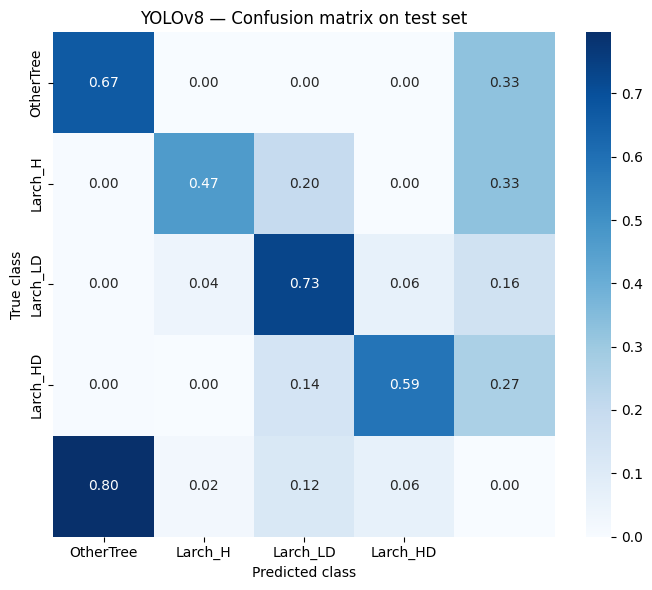

In [ ]:

# ===================== 4) Train YOLOv8 (detection of damaged Larch trees among others) =====================
EPOCHS = 100

yolo_model = YOLO("yolov8n.pt")

results = yolo_model.train(
    data=str(YOLO_ROOT / "data.yaml"),
    epochs=EPOCHS,
    imgsz=640,
    batch=16,
    device=0 if tf.config.list_physical_devices("GPU") else "cpu"
)

print("\nTraining finished. Now evaluating on TEST split...")

# ===================== 5) Evaluation on test split =====================
metrics = yolo_model.val(
    data=str(YOLO_ROOT / "data.yaml"),
    split="test",
    imgsz=640,
    batch=16,
    device=0 if tf.config.list_physical_devices("GPU") else "cpu"
)

print("\n=== YOLOv8 Detection Metrics (test) ===")
print(f"mAP@0.5: {metrics.box.map50:.4f}")
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
print("Per-class mAP@0.5:")
for cname, v in zip(yolo_class_names, metrics.box.maps):
    print(f"  {cname}: {float(v):.4f}")

# Confusion matrix
cm = metrics.confusion_matrix.matrix 
print("\nRaw confusion matrix (rows=true, cols=pred):")
print(cm)

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f",
            xticklabels=yolo_class_names, yticklabels=yolo_class_names,
            cmap="Blues")
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("YOLOv8 — Confusion matrix on test set")
plt.tight_layout()
plt.show()

Using weights: runs/detect/train/weights/best.pt
Number of test images: 230
Sample images:
 - B05_0135.JPG
 - B06_0060.JPG
 - B02_0025.JPG
 - B04_0143.JPG
 - B05_0099.JPG
 - B04_0081.JPG


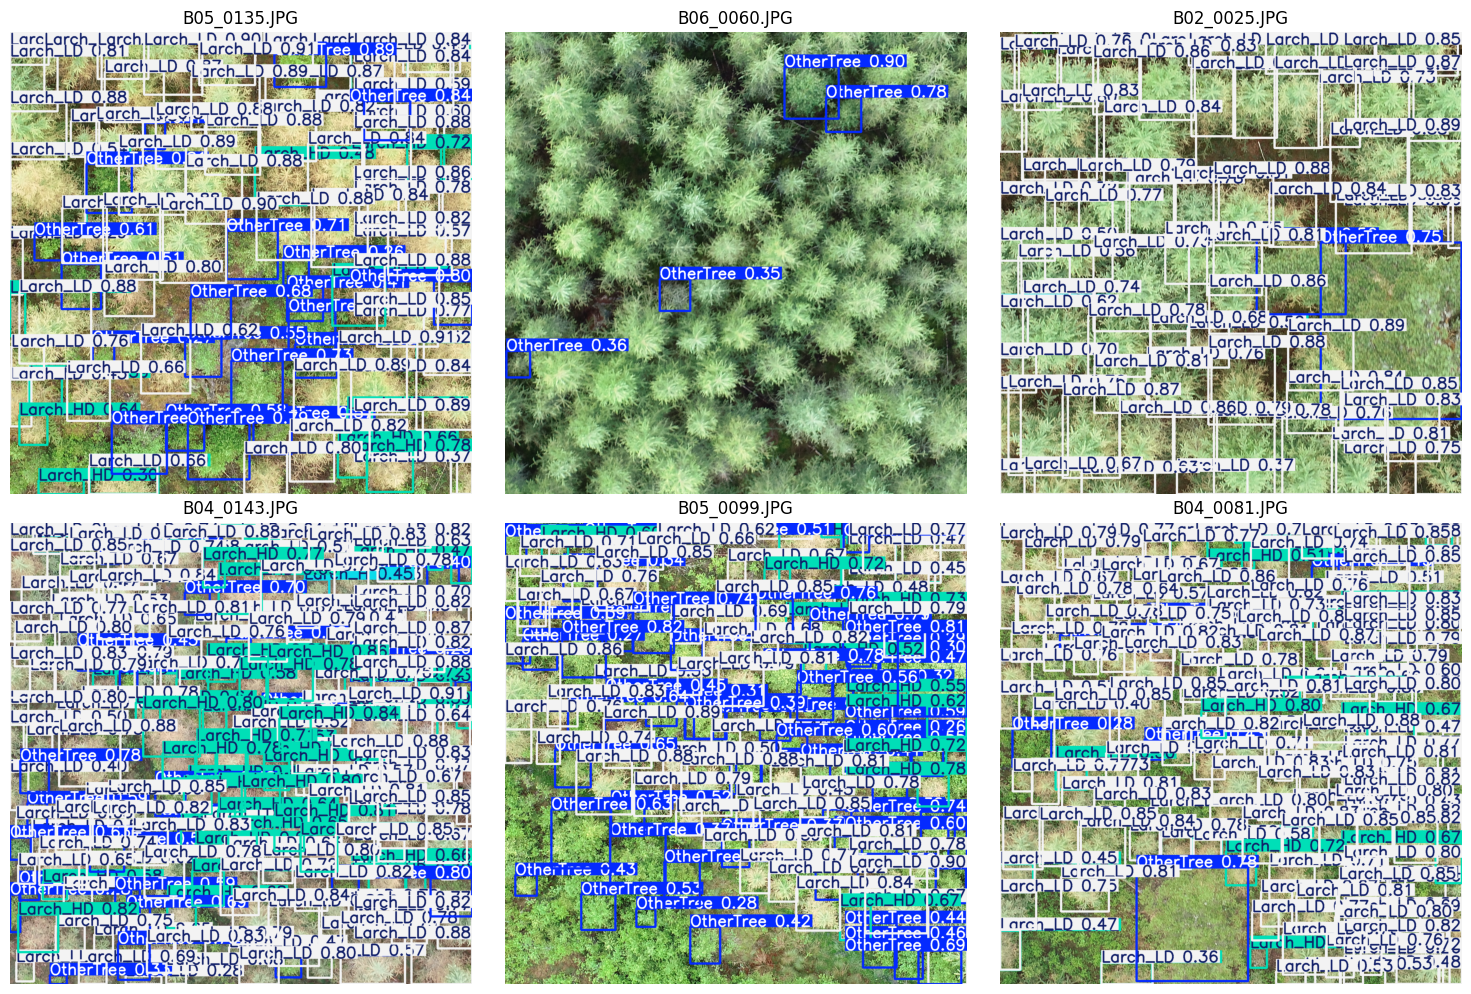

In [ ]:
# Practical demo: run trained YOLO on some test images 
import random
from pathlib import Path
import matplotlib.pyplot as plt

from ultralytics import YOLO  # safe if already imported
import numpy as np

# 1) Load best weights; By default Ultralytics saves in runs/detect/train/weights/best.pt
BEST_WEIGHTS = Path("runs/detect/train/weights/best.pt")

print("Using weights:", BEST_WEIGHTS)

# 2) Pick some test images
test_img_dir = YOLO_ROOT / "images" / "test"
test_imgs = sorted(list(test_img_dir.glob("*.JPG")) + list(test_img_dir.glob("*.jpg")))
print("Number of test images:", len(test_imgs))

n_samples = min(6, len(test_imgs))
sample_paths = random.sample(test_imgs, n_samples)
print("Sample images:")
for p in sample_paths:
    print(" -", p.name)

# 3) Run prediction
results = yolo_model.predict(
    source=[str(p) for p in sample_paths],
    imgsz=640,
    conf=0.25,      
    device=0,
    verbose=False
)

# 4) Visualize with bounding boxes
cols = 3
rows = int(np.ceil(len(results)/cols))
plt.figure(figsize=(5*cols, 5*rows))

for i, (r, img_path) in enumerate(zip(results, sample_paths)):
    annotated = r.plot() 
    annotated = annotated[..., ::-1] 

    plt.subplot(rows, cols, i+1)
    plt.imshow(annotated)
    plt.axis("off")
    plt.title(img_path.name)

plt.tight_layout()
plt.show()
